In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTConfig
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

In [2]:
# Path to the dataset
data_dir = r'C:\Users\Demyd Zaborskyi\.cache\kagglehub\datasets\itsahmad\indoor-scenes-cvpr-2019\versions\1\indoorCVPR_09\Images'

# Transforms for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transforms for the validation and test sets
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Split into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transforms to validation and test sets
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Data loader parameters
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 67


In [3]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4070


In [4]:
# =========================
# 1. Model with LoRA
# =========================

# Load pre-trained ViT model
model_lora = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model_lora.config.num_labels = num_classes
model_lora.classifier = nn.Linear(model_lora.classifier.in_features, num_classes)

# LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="IMAGE_CLASSIFICATION"
)

# Apply LoRA to the model
model_lora = get_peft_model(model_lora, lora_config)

# Freeze all parameters except LoRA parameters and classifier
for name, param in model_lora.named_parameters():
    if "lora_" not in name and "classifier" not in name:
        param.requires_grad = False

# Check which parameters will be fine-tuned
print("\nParameters to be fine-tuned (LoRA):")
for name, param in model_lora.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Move the model to the device
model_lora.to(device)

# Set up optimizer and criterion
criterion = nn.CrossEntropyLoss()
optimizer_lora = optim.Adam(filter(lambda p: p.requires_grad, model_lora.parameters()), lr=1e-4)



Parameters to be fine-tuned (LoRA):
base_model.model.vit.encoder.layer.0.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
base_model.model.vit.encoder.layer.0.attention.attention.query.lora_B.default.weight torch.Size([768, 8])
base_model.model.vit.encoder.layer.0.attention.attention.value.lora_A.default.weight torch.Size([8, 768])
base_model.model.vit.encoder.layer.0.attention.attention.value.lora_B.default.weight torch.Size([768, 8])
base_model.model.vit.encoder.layer.1.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
base_model.model.vit.encoder.layer.1.attention.attention.query.lora_B.default.weight torch.Size([768, 8])
base_model.model.vit.encoder.layer.1.attention.attention.value.lora_A.default.weight torch.Size([8, 768])
base_model.model.vit.encoder.layer.1.attention.attention.value.lora_B.default.weight torch.Size([768, 8])
base_model.model.vit.encoder.layer.2.attention.attention.query.lora_A.default.weight torch.Size([8, 768])
base_mode

In [12]:
# =========================
# 2. Model with Custom Adapter (Dynamic Multiscale Adapter)
# =========================

class DynamicMultiscaleAdapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64, scales=[1, 2, 3]):
        super(DynamicMultiscaleAdapter, self).__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, adapter_dim),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(adapter_dim, input_dim)
            ) for _ in scales
        ])
        self.attention = nn.Linear(input_dim, len(scales))

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_dim)
        adapted_outputs = [adapter(x) for adapter in self.adapters]  # List of tensors, each (batch_size, seq_len, hidden_dim)
        adapted = torch.stack(adapted_outputs, dim=2)  # (batch_size, seq_len, scales, hidden_dim)
        
        scores = self.attention(x).softmax(dim=-1).unsqueeze(-1)  # (batch_size, seq_len, scales, 1)
        
        # Multiply and sum over scales
        adapted = (adapted * scores).sum(dim=2)  # (batch_size, seq_len, hidden_dim)
        
        return x + adapted

class ViTWithCustomAdapter(nn.Module):
    def __init__(self, base_model, adapter_dim=64, scales=[1, 2, 3]):
        super(ViTWithCustomAdapter, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.config.num_labels
        self.hidden_size = base_model.config.hidden_size

        # Add custom adapter to each transformer block
        for idx, block in enumerate(self.base_model.vit.encoder.layer):
            block.custom_adapter = DynamicMultiscaleAdapter(self.hidden_size, adapter_dim, scales)

        # Replace classifier
        self.base_model.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, pixel_values):
        outputs = self.base_model.vit(
            pixel_values=pixel_values,
            output_hidden_states=False,
            return_dict=True
        )
        x = outputs.last_hidden_state

        # Apply custom adapters
        for idx, block in enumerate(self.base_model.vit.encoder.layer):
            x = block.custom_adapter(x)

        x = self.base_model.vit.layernorm(x)
        pooled_output = x[:, 0]
        logits = self.base_model.classifier(pooled_output)

        return logits

# Load base ViT model for Custom Adapter
base_vit_custom = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
base_vit_custom.config.num_labels = num_classes
model_custom_adapter = ViTWithCustomAdapter(base_vit_custom, adapter_dim=64, scales=[1, 2, 3])

# Freeze all parameters except adapters and classifier
for name, param in model_custom_adapter.named_parameters():
    if "custom_adapter" not in name and "classifier" not in name:
        param.requires_grad = False

# Check which parameters will be fine-tuned
print("\nParameters to be fine-tuned (Custom Adapter):")
for name, param in model_custom_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Move the model to the device
model_custom_adapter.to(device)

# Set up optimizer and criterion
criterion_custom = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(filter(lambda p: p.requires_grad, model_custom_adapter.parameters()), lr=1e-4)




Parameters to be fine-tuned (Custom Adapter):
base_model.vit.encoder.layer.0.custom_adapter.adapters.0.0.weight torch.Size([64, 768])
base_model.vit.encoder.layer.0.custom_adapter.adapters.0.0.bias torch.Size([64])
base_model.vit.encoder.layer.0.custom_adapter.adapters.0.3.weight torch.Size([768, 64])
base_model.vit.encoder.layer.0.custom_adapter.adapters.0.3.bias torch.Size([768])
base_model.vit.encoder.layer.0.custom_adapter.adapters.1.0.weight torch.Size([64, 768])
base_model.vit.encoder.layer.0.custom_adapter.adapters.1.0.bias torch.Size([64])
base_model.vit.encoder.layer.0.custom_adapter.adapters.1.3.weight torch.Size([768, 64])
base_model.vit.encoder.layer.0.custom_adapter.adapters.1.3.bias torch.Size([768])
base_model.vit.encoder.layer.0.custom_adapter.adapters.2.0.weight torch.Size([64, 768])
base_model.vit.encoder.layer.0.custom_adapter.adapters.2.0.bias torch.Size([64])
base_model.vit.encoder.layer.0.custom_adapter.adapters.2.3.weight torch.Size([768, 64])
base_model.vit.enc

In [6]:
# =========================
# 3. Model with Adapter Tuning
# =========================

class Adapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64):
        super(Adapter, self).__init__()
        self.linear_down = nn.Linear(input_dim, adapter_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear_up = nn.Linear(adapter_dim, input_dim)

    def forward(self, x):
        down = self.linear_down(x)
        activated = self.activation(down)
        dropped = self.dropout(activated)
        up = self.linear_up(dropped)
        return x + up  # Residual connection

class ViTWithAdapters(nn.Module):
    def __init__(self, base_model, adapter_dim=64):
        super(ViTWithAdapters, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.config.num_labels
        self.hidden_size = base_model.config.hidden_size

        # Add adapter to each transformer block
        for idx, block in enumerate(self.base_model.vit.encoder.layer):
            block.adapter = Adapter(self.hidden_size, adapter_dim)

        # Replace classifier
        self.base_model.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, pixel_values):
        outputs = self.base_model.vit(
            pixel_values=pixel_values,
            output_hidden_states=False,
            return_dict=True
        )
        x = outputs.last_hidden_state

        # Apply adapters
        for idx, block in enumerate(self.base_model.vit.encoder.layer):
            x = block.adapter(x)

        x = self.base_model.vit.layernorm(x)
        pooled_output = x[:, 0]
        logits = self.base_model.classifier(pooled_output)

        return logits

# Load base ViT model for Adapter Tuning
base_vit_adapter = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
base_vit_adapter.config.num_labels = num_classes
model_adapter = ViTWithAdapters(base_vit_adapter, adapter_dim=64)

# Freeze all parameters except adapters and classifier
for name, param in model_adapter.named_parameters():
    if "adapter" not in name and "classifier" not in name:
        param.requires_grad = False

# Check which parameters will be fine-tuned
print("\nParameters to be fine-tuned (Adapter Tuning):")
for name, param in model_adapter.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

# Move the model to the device
model_adapter.to(device)

# Set up optimizer and criterion
criterion_adapter = nn.CrossEntropyLoss()
optimizer_adapter = optim.Adam(filter(lambda p: p.requires_grad, model_adapter.parameters()), lr=1e-4)


Parameters to be fine-tuned (Adapter Tuning):
base_model.vit.encoder.layer.0.adapter.linear_down.weight torch.Size([64, 768])
base_model.vit.encoder.layer.0.adapter.linear_down.bias torch.Size([64])
base_model.vit.encoder.layer.0.adapter.linear_up.weight torch.Size([768, 64])
base_model.vit.encoder.layer.0.adapter.linear_up.bias torch.Size([768])
base_model.vit.encoder.layer.1.adapter.linear_down.weight torch.Size([64, 768])
base_model.vit.encoder.layer.1.adapter.linear_down.bias torch.Size([64])
base_model.vit.encoder.layer.1.adapter.linear_up.weight torch.Size([768, 64])
base_model.vit.encoder.layer.1.adapter.linear_up.bias torch.Size([768])
base_model.vit.encoder.layer.2.adapter.linear_down.weight torch.Size([64, 768])
base_model.vit.encoder.layer.2.adapter.linear_down.bias torch.Size([64])
base_model.vit.encoder.layer.2.adapter.linear_up.weight torch.Size([768, 64])
base_model.vit.encoder.layer.2.adapter.linear_up.bias torch.Size([768])
base_model.vit.encoder.layer.3.adapter.linea

In [7]:
# =========================
# Functions for Training and Evaluation
# =========================

import warnings
warnings.filterwarnings("ignore", message="Torch was not compiled with flash attention")

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, model_name='model'):
    best_val_acc = 0.0
    total_training_time = 0.0  # Variable to store total training time

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time measurement for the epoch

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(pixel_values=inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(pixel_values=inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs

                loss = criterion(logits, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        end_time = time.time()  # End time measurement for the epoch
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # Save the best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')

    print(f"Best Validation Accuracy for {model_name}: {best_val_acc:.4f}")
    print(f"Total Training Time for {model_name}: {total_training_time:.2f}s")
    return total_training_time  # Return total training time

def evaluate_model(model, test_loader, device, class_names, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []  # List to store inference times

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()  # Start time measurement for inference
            outputs = model(pixel_values=inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            end_time = time.time()  # End time measurement for inference

            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            inference_times.append(end_time - start_time)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"\nTest Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, precision, recall, f1, avg_inference_time, cm

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Training the Models

In [8]:
# Training the model with LoRA
print("\n=== Training model with LoRA ===")
training_time_lora = train_model(
    model=model_lora,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_lora,
    device=device,
    num_epochs=10,
    model_name='model_lora'
)


=== Training model with LoRA ===


C:\Anaconda\envs\cuda_test\lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/10 | Train Loss: 3.5735 | Train Acc: 0.2004 | Val Loss: 2.7390 | Val Acc: 0.3922 | Time: 92.35s
Epoch 2/10 | Train Loss: 2.3144 | Train Acc: 0.4823 | Val Loss: 1.9939 | Val Acc: 0.5493 | Time: 93.15s
Epoch 3/10 | Train Loss: 1.7696 | Train Acc: 0.6099 | Val Loss: 1.6203 | Val Acc: 0.6458 | Time: 95.35s
Epoch 4/10 | Train Loss: 1.4479 | Train Acc: 0.6874 | Val Loss: 1.4005 | Val Acc: 0.6872 | Time: 93.77s
Epoch 5/10 | Train Loss: 1.2364 | Train Acc: 0.7387 | Val Loss: 1.2432 | Val Acc: 0.7217 | Time: 92.98s
Epoch 6/10 | Train Loss: 1.0832 | Train Acc: 0.7827 | Val Loss: 1.1468 | Val Acc: 0.7495 | Time: 94.97s
Epoch 7/10 | Train Loss: 0.9705 | Train Acc: 0.8078 | Val Loss: 1.0745 | Val Acc: 0.7618 | Time: 96.36s
Epoch 8/10 | Train Loss: 0.8787 | Train Acc: 0.8332 | Val Loss: 1.0156 | Val Acc: 0.7738 | Time: 101.58s
Epoch 9/10 | Train Loss: 0.8021 | Train Acc: 0.8549 | Val Loss: 0.9763 | Val Acc: 0.7776 | Time: 95.57s
Epoch 10/10 | Train Loss: 0.7379 | Train Acc: 0.8712 | Val Loss

In [9]:
class_names = full_dataset.classes


=== Evaluating model with LoRA ===

Test Metrics for LoRA:
Accuracy: 0.7973
Precision: 0.8071
Recall: 0.7973
F1-Score: 0.7865
Average Inference Time per Batch: 0.0067s


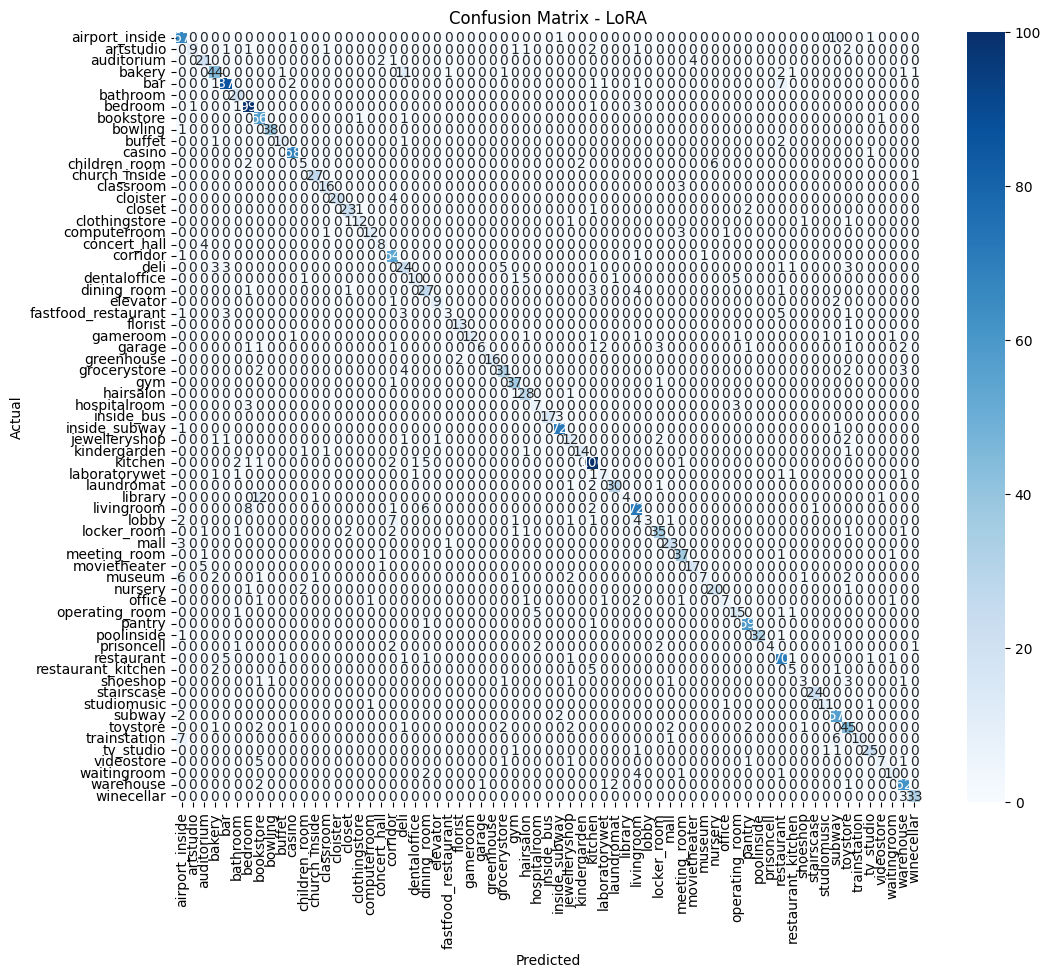


LoRA Model - Total Parameters: 86145091, Trainable Parameters: 294912


In [10]:
# Evaluating the model with LoRA
print("\n=== Evaluating model with LoRA ===")
model_lora.load_state_dict(torch.load('best_model_lora.pth'))
model_lora.to(device)
acc_lora, precision_lora, recall_lora, f1_lora, inference_time_lora, cm_lora = evaluate_model(
    model=model_lora,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='LoRA'
)

# Counting parameters of the LoRA model
total_params_lora, trainable_params_lora = count_parameters(model_lora)
print(f"\nLoRA Model - Total Parameters: {total_params_lora}, Trainable Parameters: {trainable_params_lora}")

In [13]:
# Training the model with Custom Adapter
print("\n=== Training model with Custom Adapter ===")
training_time_custom_adapter = train_model(
    model=model_custom_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_custom,
    optimizer=optimizer_custom,
    device=device,
    num_epochs=10,
    model_name='model_custom_adapter'
)


=== Training model with Custom Adapter ===
Epoch 1/10 | Train Loss: 1.6068 | Train Acc: 0.6655 | Val Loss: 0.6277 | Val Acc: 0.8357 | Time: 65.38s
Epoch 2/10 | Train Loss: 0.6101 | Train Acc: 0.8418 | Val Loss: 0.5112 | Val Acc: 0.8515 | Time: 67.65s
Epoch 3/10 | Train Loss: 0.4588 | Train Acc: 0.8743 | Val Loss: 0.4814 | Val Acc: 0.8566 | Time: 68.44s
Epoch 4/10 | Train Loss: 0.3840 | Train Acc: 0.8904 | Val Loss: 0.4713 | Val Acc: 0.8609 | Time: 66.34s
Epoch 5/10 | Train Loss: 0.3183 | Train Acc: 0.9085 | Val Loss: 0.4613 | Val Acc: 0.8609 | Time: 66.08s
Epoch 6/10 | Train Loss: 0.2682 | Train Acc: 0.9242 | Val Loss: 0.4658 | Val Acc: 0.8660 | Time: 65.17s
Epoch 7/10 | Train Loss: 0.2262 | Train Acc: 0.9364 | Val Loss: 0.4687 | Val Acc: 0.8643 | Time: 65.53s
Epoch 8/10 | Train Loss: 0.1988 | Train Acc: 0.9451 | Val Loss: 0.4716 | Val Acc: 0.8634 | Time: 65.33s
Epoch 9/10 | Train Loss: 0.1660 | Train Acc: 0.9534 | Val Loss: 0.4671 | Val Acc: 0.8707 | Time: 65.39s
Epoch 10/10 | Train 


=== Evaluating model with Custom Adapter ===

Test Metrics for Custom Adapter:
Accuracy: 0.8634
Precision: 0.8674
Recall: 0.8634
F1-Score: 0.8634
Average Inference Time per Batch: 0.0085s


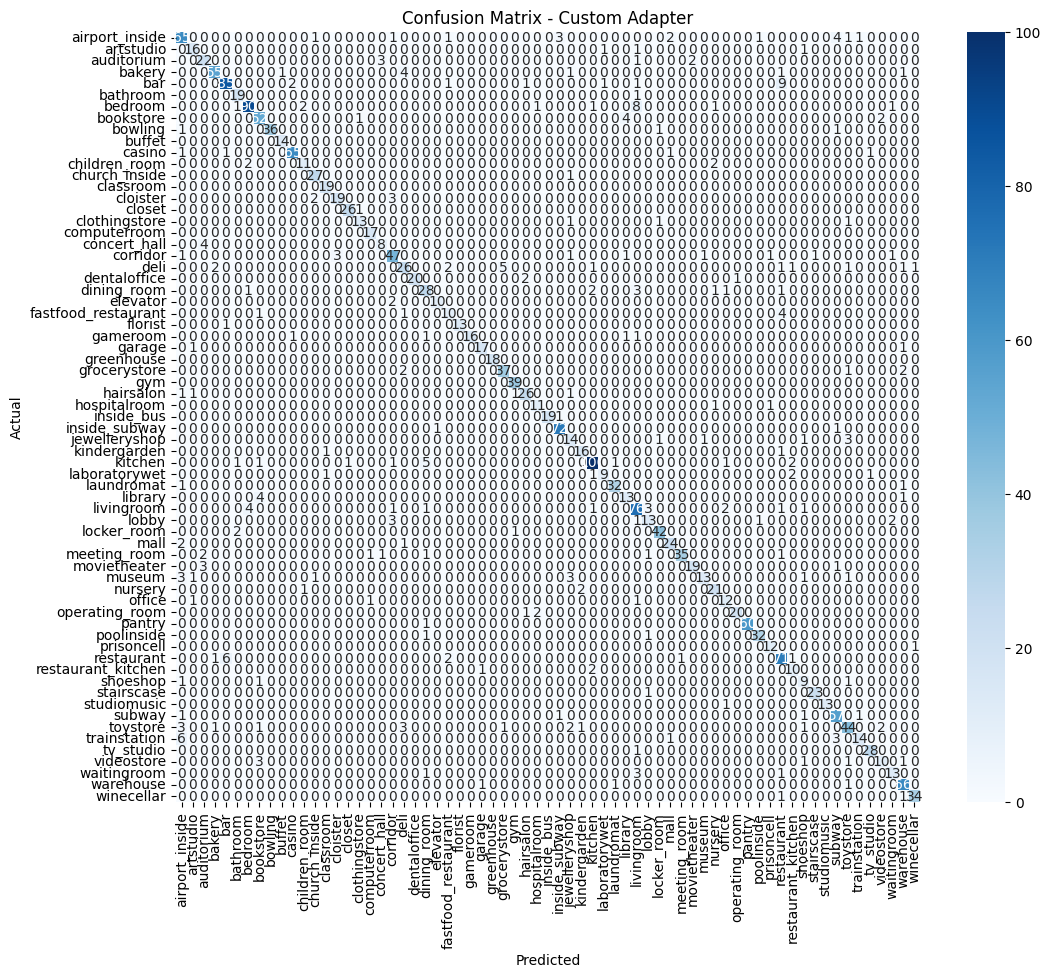


Custom Adapter Model - Total Parameters: 89446759, Trainable Parameters: 3648103


In [14]:
# Evaluating the model with Custom Adapter
print("\n=== Evaluating model with Custom Adapter ===")
model_custom_adapter.load_state_dict(torch.load('best_model_custom_adapter.pth'))
model_custom_adapter.to(device)
acc_custom_adapter, precision_custom_adapter, recall_custom_adapter, f1_custom_adapter, inference_time_custom_adapter, cm_custom_adapter = evaluate_model(
    model=model_custom_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Custom Adapter'
)

# Counting parameters of the Custom Adapter model
total_params_custom_adapter, trainable_params_custom_adapter = count_parameters(model_custom_adapter)
print(f"\nCustom Adapter Model - Total Parameters: {total_params_custom_adapter}, Trainable Parameters: {trainable_params_custom_adapter}")

In [15]:
print("\n=== Training model with Adapter Tuning ===")
training_time_adapter = train_model(
    model=model_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_adapter,
    optimizer=optimizer_adapter,
    device=device,
    num_epochs=10,
    model_name='model_adapter'
)


=== Training model with Adapter Tuning ===
Epoch 1/10 | Train Loss: 1.9815 | Train Acc: 0.5846 | Val Loss: 0.7746 | Val Acc: 0.7879 | Time: 53.45s
Epoch 2/10 | Train Loss: 0.7725 | Train Acc: 0.8151 | Val Loss: 0.5515 | Val Acc: 0.8361 | Time: 53.15s
Epoch 3/10 | Train Loss: 0.5604 | Train Acc: 0.8524 | Val Loss: 0.5164 | Val Acc: 0.8451 | Time: 53.87s
Epoch 4/10 | Train Loss: 0.4654 | Train Acc: 0.8690 | Val Loss: 0.4873 | Val Acc: 0.8540 | Time: 55.50s
Epoch 5/10 | Train Loss: 0.4046 | Train Acc: 0.8860 | Val Loss: 0.4742 | Val Acc: 0.8545 | Time: 53.93s
Epoch 6/10 | Train Loss: 0.3539 | Train Acc: 0.8978 | Val Loss: 0.4742 | Val Acc: 0.8570 | Time: 53.80s
Epoch 7/10 | Train Loss: 0.3156 | Train Acc: 0.9114 | Val Loss: 0.4685 | Val Acc: 0.8570 | Time: 55.30s
Epoch 8/10 | Train Loss: 0.2802 | Train Acc: 0.9193 | Val Loss: 0.4651 | Val Acc: 0.8613 | Time: 53.69s
Epoch 9/10 | Train Loss: 0.2522 | Train Acc: 0.9293 | Val Loss: 0.4713 | Val Acc: 0.8668 | Time: 53.31s
Epoch 10/10 | Train 


=== Evaluating model with Adapter Tuning ===

Test Metrics for Adapter Tuning:
Accuracy: 0.8621
Precision: 0.8664
Recall: 0.8621
F1-Score: 0.8618
Average Inference Time per Batch: 0.0054s


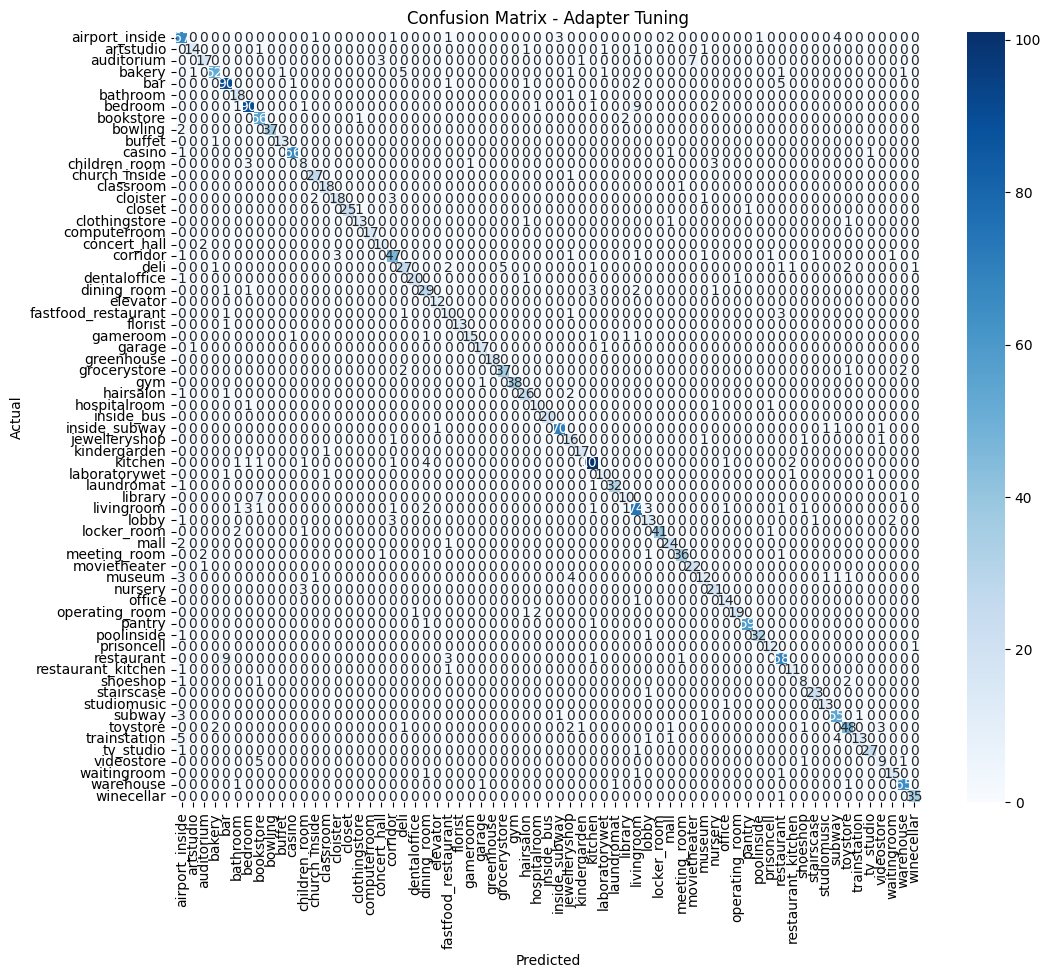


Adapter Tuning Model - Total Parameters: 87039811, Trainable Parameters: 1241155


In [16]:
# Evaluating the model with Adapter Tuning
print("\n=== Evaluating model with Adapter Tuning ===")
model_adapter.load_state_dict(torch.load('best_model_adapter.pth'))
model_adapter.to(device)
acc_adapter, precision_adapter, recall_adapter, f1_adapter, inference_time_adapter, cm_adapter = evaluate_model(
    model=model_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Adapter Tuning'
)

# Counting parameters of the Adapter Tuning model
total_params_adapter, trainable_params_adapter = count_parameters(model_adapter)
print(f"\nAdapter Tuning Model - Total Parameters: {total_params_adapter}, Trainable Parameters: {trainable_params_adapter}")

In [17]:
# Creating a summary table with results
data = {
    'Model': ['LoRA', 'Custom Adapter', 'Adapter Tuning'],
    'Accuracy': [acc_lora, acc_custom_adapter, acc_adapter],
    'Precision': [precision_lora, precision_custom_adapter, precision_adapter],
    'Recall': [recall_lora, recall_custom_adapter, recall_adapter],
    'F1-Score': [f1_lora, f1_custom_adapter, f1_adapter],
    'Training Time (s)': [training_time_lora, training_time_custom_adapter, training_time_adapter],
    'Inference Time (s)': [inference_time_lora, inference_time_custom_adapter, inference_time_adapter],
    'Total Params': [total_params_lora, total_params_custom_adapter, total_params_adapter],
    'Trainable Params': [trainable_params_lora, trainable_params_custom_adapter, trainable_params_adapter],
}

df_results = pd.DataFrame(data)
print("\nPEFT comparative analysis:")
print(df_results)


PEFT comparative analysis:
            Model  Accuracy  Precision    Recall  F1-Score  Training Time (s)  \
0            LoRA  0.797268   0.807052  0.797268  0.786478         950.016522   
1  Custom Adapter  0.863423   0.867389  0.863423  0.863434         660.578506   
2  Adapter Tuning  0.862143   0.866423  0.862143  0.861827         541.827820   

   Inference Time (s)  Total Params  Trainable Params  
0            0.006730      86145091            294912  
1            0.008542      89446759           3648103  
2            0.005397      87039811           1241155  
